# Algorithmic Fairness, Accountability, and Ethics, Spring 2025

## Mandatory Assignment 1

Please use the following code to prepare the dataset.
 

In [131]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from scipy.stats import zscore

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

# Task 1 - Classifiers and fairness considerations
## Feature engineering and scaling
### Standardizing the age data

Firstly we want to convert the age data to range between 0 and 1, since all other given features are categorical and one-hot-encoded. This is to ensure comparability for the feature wheigts. 

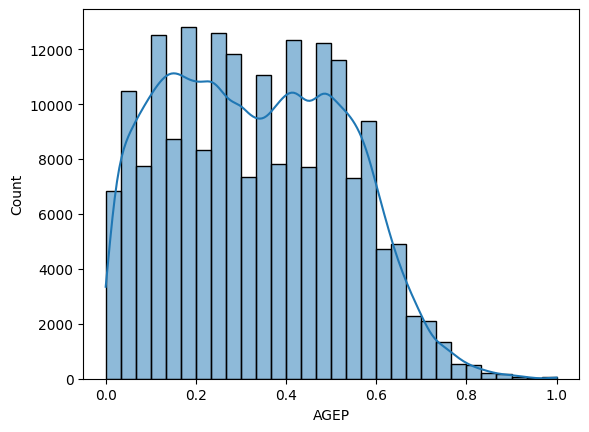

In [132]:
# Standardized age dataset
dataS = data.copy()

scaler=MinMaxScaler()
dataS["AGEP"]=scaler.fit_transform(data[["AGEP"]])

sns.histplot(dataS["AGEP"], bins=30, kde=True)  
plt.show()

## Getting a feeling of the categorical data
### Citizenship

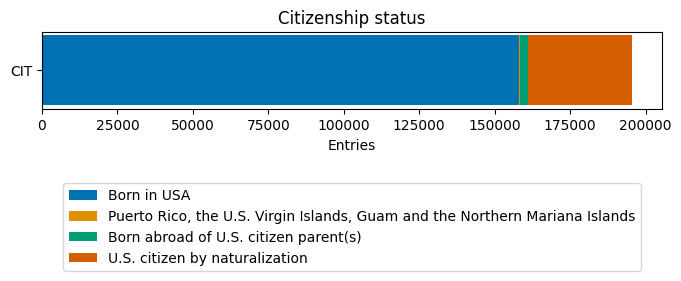

In [133]:
# Sample data for one stacked bar
labels = ["Born in USA", "Puerto Rico, the U.S. Virgin Islands, Guam and the Northern Mariana Islands", "Born abroad of U.S. citizen parent(s)", "U.S. citizen by naturalization", "Not U.S. citizen"]
values = [sum(data[f"CIT_{i}"]) for i in range(2, 5)]
values = [len(data)-sum(values)]+values
Ncat=len(values)
colors =sns.color_palette('colorblind', Ncat)

# Create the horizontal stacked bar
fig, ax = plt.subplots(figsize=(8, 1))
ax.barh(["CIT"], values[0], color=colors[0], label=labels[0])

for i in range(1,Ncat):
    ax.barh(["CIT"], values[i], left=sum(values[0:i]), color=colors[i], label=labels[i])
 
# Labels and legend
ax.set_xlabel("Entries")
ax.set_title("Citizenship status")
ax.legend(loc='lower center',bbox_to_anchor=(0.5, -2.2))

# Show plot
plt.show()

### Working class

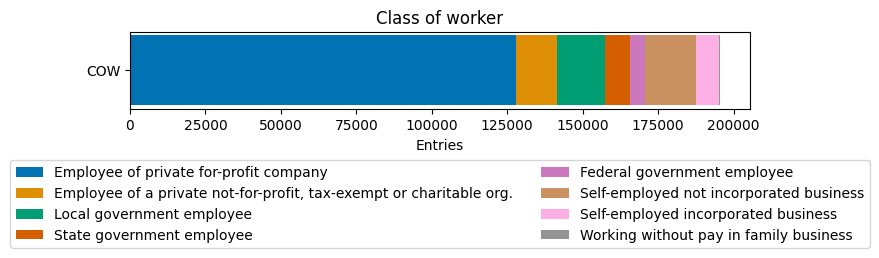

In [134]:
# Sample data for one stacked bar
labels = ["Employee of private for-profit company", "Employee of a private not-for-profit, tax-exempt or charitable org.", "Local government employee", "State government employee", "Federal government employee", "Self-employed not incorporated business", "Self-employed incorporated business", "Working without pay in family business"]#, "Unemployed at least 5 years"]
values = [sum(data[f"COW_{i}.0"]) for i in range(2, 9)]
values = [len(data)-sum(values)]+values
# Number of categories
Ncat=len(values)

# Choosing color for stacked bar
colors =sns.color_palette('colorblind', Ncat)

# Create the horizontal stacked bar
fig, ax = plt.subplots(figsize=(8, 1))
ax.barh(["COW"], values[0], color=colors[0], label=labels[0])

for i in range(1,Ncat):
    ax.barh(["COW"], values[i], left=sum(values[0:i]), color=colors[i], label=labels[i])
 
# Labels and legend
ax.set_xlabel("Entries")
ax.set_title("Class of worker")
ax.legend(loc='lower center',bbox_to_anchor=(0.5, -1.9),ncol=2)

# Show plot
plt.show()

### Educational attainment

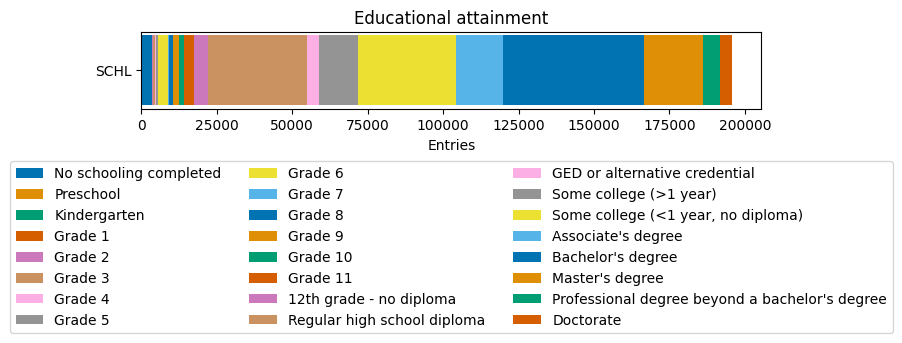

In [135]:
# Sample data for one stacked bar
labels = ["No schooling completed","Preschool", "Kindergarten", "Grade 1", "Grade 2", "Grade 3", "Grade 4", "Grade 5", "Grade 6", "Grade 7", "Grade 8", "Grade 9", "Grade 10", "Grade 11", "12th grade - no diploma","Regular high school diploma","GED or alternative credential","Some college (>1 year)", "Some college (<1 year, no diploma)","Associate's degree","Bachelor's degree","Master's degree","Professional degree beyond a bachelor's degree","Doctorate"]
values = [sum(data[f"SCHL_{i}.0"]) for i in range(2, 25)]
values = [len(data)-sum(values)]+values
# Number of categories
Ncat=len(values)

# Choosing color for stacked bar
colors =sns.color_palette('colorblind', Ncat)

# Create the horizontal stacked bar
fig, ax = plt.subplots(figsize=(8, 1))
ax.barh(["SCHL"], values[0], color=colors[0], label=labels[0])

for i in range(1,Ncat):
    ax.barh(["SCHL"], values[i], left=sum(values[0:i]), color=colors[i], label=labels[i])
 
# Labels and legend
ax.set_xlabel("Entries")
ax.set_title("Educational attainment")
ax.legend(loc='lower center',bbox_to_anchor=(0.5, -3),ncol=3)

# Show plot
plt.show()

In [136]:
dataS["SCHL_4.0"]=data["SCHL_4.0"] | data["SCHL_5.0"] | data["SCHL_6.0"] | data["SCHL_7.0"] | data["SCHL_8.0"]
dataS["SCHL_5.0"]=data["SCHL_9.0"] | data["SCHL_10.0"] | data["SCHL_11.0"]
dataS["SCHL_6.0"]=data["SCHL_12.0"] | data["SCHL_13.0"] | data["SCHL_14.0"] | data["SCHL_15.0"]


for i in range(16,25):
    dataS[f"SCHL_{i-9}.0"]=dataS[f"SCHL_{i}.0"]
    if i>16:
        dataS = dataS.drop([f"SCHL_{i}.0"],axis=1)


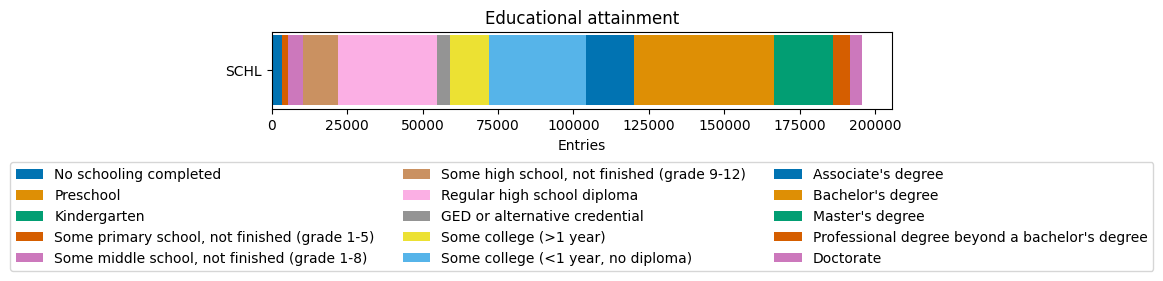

In [137]:
# Sample data for one stacked bar
labels = ["No schooling completed","Preschool", "Kindergarten", "Some primary school, not finished (grade 1-5)", "Some middle school, not finished (grade 1-8)", "Some high school, not finished (grade 9-12)","Regular high school diploma","GED or alternative credential","Some college (>1 year)", "Some college (<1 year, no diploma)","Associate's degree","Bachelor's degree","Master's degree","Professional degree beyond a bachelor's degree","Doctorate"]
values = [sum(dataS[f"SCHL_{i}.0"]) for i in range(2, 16)]
values = [len(dataS)-sum(values)]+values
# Number of categories
Ncat=len(values)

# Choosing color for stacked bar
colors =sns.color_palette('colorblind', 16)

# Create the horizontal stacked bar
fig, ax = plt.subplots(figsize=(8, 1))
ax.barh(["SCHL"], values[0], color=colors[0], label=labels[0])

for i in range(1,15):
    ax.barh(["SCHL"], values[i], left=sum(values[0:i]), color=colors[i], label=labels[i])
 
# Labels and legend
ax.set_xlabel("Entries")
ax.set_title("Educational attainment")
ax.legend(loc='lower center',bbox_to_anchor=(0.5, -2.2),ncol=3)

# Show plot
plt.show()

Grouping data entries for not completing high school. We group the data correspondingly <br>
<br>
preschool-kindergarden <br>
1st-5th grade primary school <br>
6th-8th grade middle school <br>
9th-12th grade high school <br>


## Marital status

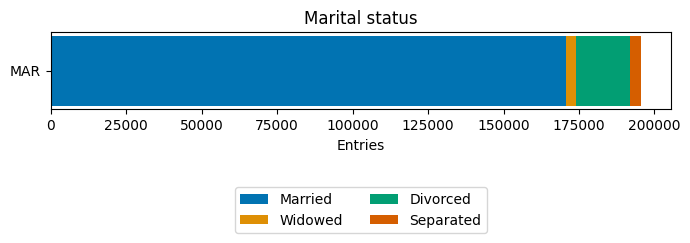

In [138]:
# Sample data for one stacked bar
labels = ["Married", "Widowed", "Divorced", "Separated", "Never married"]
values =  [sum(data[f"MAR_{i}"]) for i in range(2, 5)]
values = [len(data)-sum(values)]+values
Ncat=len(values)
colors =sns.color_palette('colorblind', Ncat)

# Create the horizontal stacked bar
fig, ax = plt.subplots(figsize=(8, 1))
ax.barh(["MAR"], values[0], color=colors[0], label=labels[0])

for i in range(1,Ncat):
    ax.barh(["MAR"], values[i], left=sum(values[0:i]), color=colors[i], label=labels[i])
 
# Labels and legend
ax.set_xlabel("Entries")
ax.set_title("Marital status")
ax.legend(loc='lower center',bbox_to_anchor=(0.5, -1.7),ncol=2)

# Show plot
plt.show()

## English abilities

## Recoded detailed race code

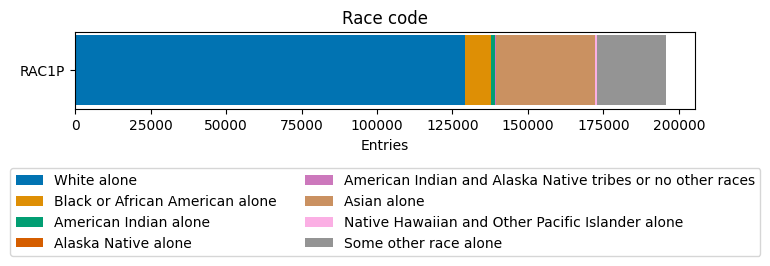

In [139]:
# Sample data for one stacked bar
labels = ["White alone","Black or African American alone","American Indian alone","Alaska Native alone","American Indian and Alaska Native tribes or no other races", "Asian alone","Native Hawaiian and Other Pacific Islander alone", "Some other race alone", "Two or more races"]
values = [sum(data[f"RAC1P_{i}"]) for i in range(2, 9)]
values = [len(data)-sum(values)]+values
# Number of categories
Ncat=len(values)

# Choosing color for stacked bar
colors =sns.color_palette('colorblind', Ncat)

# Create the horizontal stacked bar
fig, ax = plt.subplots(figsize=(8, 1))
ax.barh(["RAC1P"], values[0], color=colors[0], label=labels[0])

for i in range(1,Ncat):
    ax.barh(["RAC1P"], values[i], left=sum(values[0:i]), color=colors[i], label=labels[i])
 
# Labels and legend
ax.set_xlabel("Entries")
ax.set_title("Race code")
ax.legend(loc='lower center',bbox_to_anchor=(0.5, -2),ncol=2)

# Show plot
plt.show()

## Insurance status

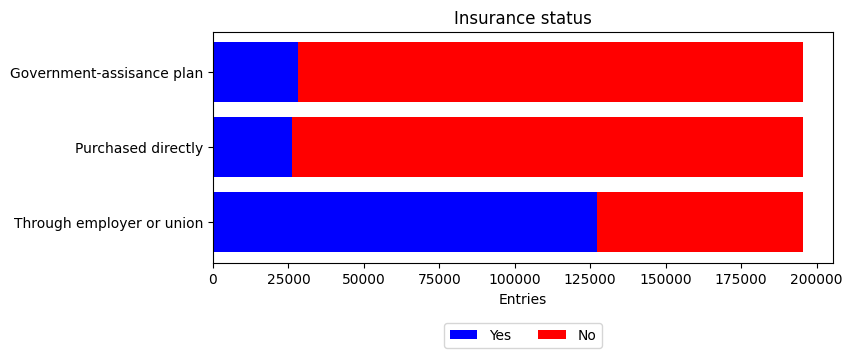

In [140]:
# Sample data for one stacked bar
labels = ["Yes", "No"]
HINS1values = [sum(data['HINS1_2'])]
HINS2values = [sum(data['HINS2_2'])]
HINS4values = [sum(data['HINS4_2'])]


HINS1values = [len(data)-sum(HINS1values)]+HINS1values
HINS2values = [len(data)-sum(HINS2values)]+HINS2values
HINS4values = [len(data)-sum(HINS4values)]+HINS4values

Ncat=2
colors =["blue","red"]

# Create the horizontal stacked bar
fig, ax = plt.subplots(figsize=(8, 3))
ax.barh(["Through employer or union"], HINS1values[0], color=colors[0], label=labels[0])
ax.barh(["Through employer or union"], HINS1values[1], left=HINS1values[0], color=colors[1], label=labels[1])

ax.barh(["Purchased directly"], HINS2values[0], color=colors[0])
ax.barh(["Purchased directly"], HINS2values[1], left=HINS2values[0], color=colors[1])

ax.barh(["Government-assisance plan"], HINS4values[0], color=colors[0])
ax.barh(["Government-assisance plan"], HINS4values[1], left=HINS4values[0], color=colors[1])


 
# Labels and legend
ax.set_xlabel("Entries")
ax.set_title("Insurance status")
ax.legend(loc='lower center',bbox_to_anchor=(0.5, -0.4),ncol=2)

# Show plot
plt.show()

## Fitting logistic regression model

In [141]:
X_trainS, X_testS, y_trainS, y_testS, group_train, group_test = train_test_split(
    dataS, target, group, test_size=0.2, random_state=0)

# Fitting a simple logistic regression model
WBmodel=LogisticRegression(max_iter=5000, penalty = "l2", C= 0.8497534359086438, tol=1e-4, solver = "saga")
WBmodel.fit(X_trainS,y_trainS)


LogisticRegression(C=0.8497534359086438, max_iter=5000, solver='saga')

### Feature wheights
OBS wheigts need to be exp-translated because we have a logistic model

<Axes: ylabel='Feature'>

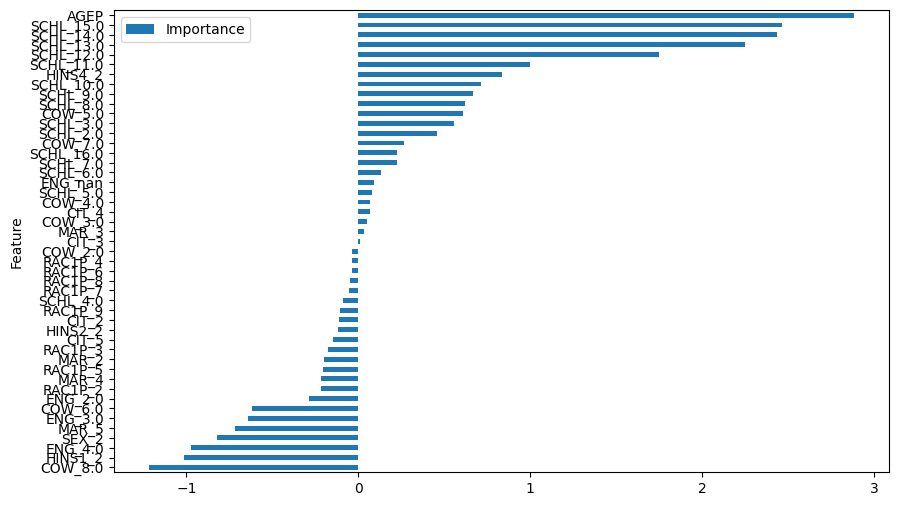

In [142]:
coefficients = WBmodel.coef_[0]

feature_importance = pd.DataFrame({'Feature': dataS.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

## Fitting a random forest model


Explanation for the feature engineering and scaling steps

In [143]:
# Set up using categorical data for RF
cols = data_original.columns

cols = cols[:-2]

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data_original[cols], target, group, test_size=0.2, random_state=0)

X_train.loc[X_train.ENG.isna(), 'ENG'] = 0 # Fill missing values with 0, shap gets upset with NaNs
X_test.loc[X_test.ENG.isna(), 'ENG'] = 0

In [144]:
from sklearn.compose import ColumnTransformer 
#Gonna scale the AGEP column this time...
scaler = ColumnTransformer(
    [('scaler', MinMaxScaler(),['AGEP'])], 
    remainder='passthrough')

scaler.fit(X_train) #Make sure we fit to the training data only, to avoid data leakage
X_train.AGEP = scaler.transform(X_train)[:,0]
X_test.AGEP = scaler.transform(X_test)[:,0]

clf = RandomForestClassifier(max_depth=5, 
                             random_state=23, 
                             n_jobs=-1, 
                             n_estimators=20) #I probably want more estimators really

clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.771778294534025

In [145]:
import shap
explainer = shap.TreeExplainer(clf, X_train, model_output='probability')
shap_values = explainer(X_test)

 98%|===================| 76717/78266 [00:51<00:01]        

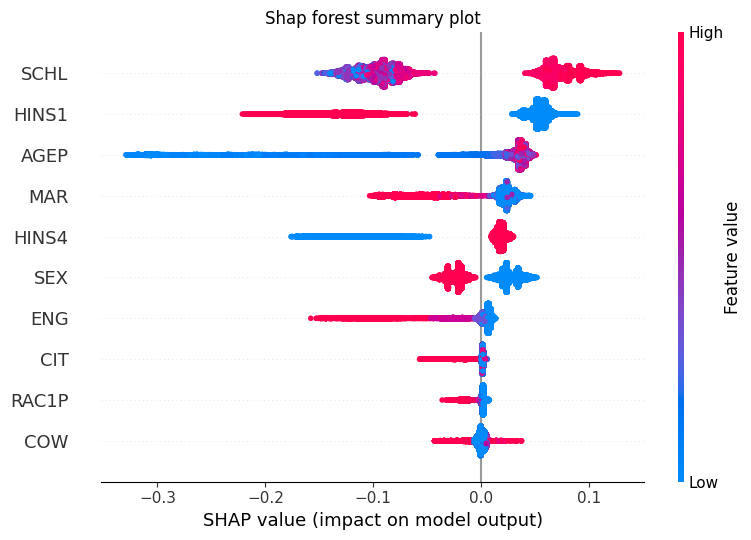

In [146]:
## Summary plot
shap.summary_plot(shap_values[:,:,1], X_test, 
                  feature_names=X_train.columns, 
                  max_display=10, show=False)

plt.title(f'Shap forest summary plot')
plt.tight_layout()

plt.show()

In [147]:
# Train your model
BBmodel = RandomForestClassifier()
BBmodel.fit(X_trainS, y_trainS)

RandomForestClassifier()

## Accuracy for the models

In [148]:
# Visualising the performance in regards to age
y_predWB=WBmodel.predict(X_testS)
y_predBB=BBmodel.predict(X_testS)

print('Accuracy White Box model =', np.sum(y_testS==y_predWB)/(len(y_testS)))
print('Accuracy Black Box model =', np.sum(y_testS==y_predBB)/(len(y_testS)))


Accuracy White Box model = 0.769580660823346
Accuracy Black Box model = 0.7459688753737255


## Fairness metrics

Statistical parity, the probability for being chosen should be the same, regardless of group

Equalised odds, the probability of being chosen should be the same, regardless of your group and target properties. Thus controlling that the true positive rates and false positive rates are respectively the same.

In [149]:
dataS.columns

Index(['AGEP', 'HINS1_2', 'HINS2_2', 'HINS4_2', 'CIT_2', 'CIT_3', 'CIT_4',
       'CIT_5', 'COW_2.0', 'COW_3.0', 'COW_4.0', 'COW_5.0', 'COW_6.0',
       'COW_7.0', 'COW_8.0', 'SCHL_2.0', 'SCHL_3.0', 'SCHL_4.0', 'SCHL_5.0',
       'SCHL_6.0', 'SCHL_7.0', 'SCHL_8.0', 'SCHL_9.0', 'SCHL_10.0',
       'SCHL_11.0', 'SCHL_12.0', 'SCHL_13.0', 'SCHL_14.0', 'SCHL_15.0',
       'SCHL_16.0', 'MAR_2', 'MAR_3', 'MAR_4', 'MAR_5', 'SEX_2', 'RAC1P_2',
       'RAC1P_3', 'RAC1P_4', 'RAC1P_5', 'RAC1P_6', 'RAC1P_7', 'RAC1P_8',
       'RAC1P_9', 'ENG_2.0', 'ENG_3.0', 'ENG_4.0', 'ENG_nan'],
      dtype='object')

In [150]:
type(y_predBB)


numpy.ndarray

In [151]:
test=np.array([1,2,3,4])

print(test[[True,False,True,False]])

[1 3]


In [152]:
## Sex
SPSEX=np.zeros(2)
SPSEX[0]=np.mean(y_predBB & X_testS["SEX_2"])
SPSEX[1]=np.mean(y_predBB & 1-X_testS["SEX_2"])

print(y_predBB)

print(X_testS["SEX_2"])

print(y_predBB & X_testS["SEX_2"])

[ True  True  True ...  True False False]
309375    False
197073    False
306289     True
173749     True
57936     False
          ...  
372590    False
272674    False
207697    False
38489      True
101244     True
Name: SEX_2, Length: 39133, dtype: bool
309375    False
197073    False
306289     True
173749    False
57936     False
          ...  
372590    False
272674    False
207697    False
38489     False
101244    False
Name: SEX_2, Length: 39133, dtype: bool


In [153]:
X_testS.columns

Index(['AGEP', 'HINS1_2', 'HINS2_2', 'HINS4_2', 'CIT_2', 'CIT_3', 'CIT_4',
       'CIT_5', 'COW_2.0', 'COW_3.0', 'COW_4.0', 'COW_5.0', 'COW_6.0',
       'COW_7.0', 'COW_8.0', 'SCHL_2.0', 'SCHL_3.0', 'SCHL_4.0', 'SCHL_5.0',
       'SCHL_6.0', 'SCHL_7.0', 'SCHL_8.0', 'SCHL_9.0', 'SCHL_10.0',
       'SCHL_11.0', 'SCHL_12.0', 'SCHL_13.0', 'SCHL_14.0', 'SCHL_15.0',
       'SCHL_16.0', 'MAR_2', 'MAR_3', 'MAR_4', 'MAR_5', 'SEX_2', 'RAC1P_2',
       'RAC1P_3', 'RAC1P_4', 'RAC1P_5', 'RAC1P_6', 'RAC1P_7', 'RAC1P_8',
       'RAC1P_9', 'ENG_2.0', 'ENG_3.0', 'ENG_4.0', 'ENG_nan'],
      dtype='object')

In [154]:
## Calculating statistical parities

SPWB=np.zeros(len(X_testS,axis=1))

# Index matrix
X_testS["SEX_1"]=1-X_testS["SEX_2"]

for i in range(1, len(X_testS,axis=1)):
    SPWB[i-1]=np.mean(y_predWB & X_testS[i])

TypeError: len() takes no keyword arguments

In [ ]:

    



## Sex
SPSEX=np.zeros(2)
SPSEX[0]=np.mean(y_predWB & X_testS["SEX_2"])
SPSEX[1]=np.mean(y_predWB & 1-X_testS["SEX_2"])

## Insurance type 1
SPHINS1=np.zeros(2)
SPHINS1[0]=np.mean(y_predWB & X_testS["HINS1_2"])
SPHINS1[1]=np.mean(y_predWB & 1-X_testS["HINS1_2"])

## Insurance type 2
SPHINS2=np.zeros(2)
SPHINS2[0]=np.mean(y_predWB & X_testS["HINS2_2"])
SPHINS2[1]=np.mean(y_predWB & 1-X_testS["HINS2_2"])

## Insurance type 4
SPHINS4=np.zeros(2)
SPHINS4[0]=np.mean(y_predWB & X_testS["HINS4_2"])
SPHINS4[1]=np.mean(y_predWB & 1-X_testS["HINS4_2"])

## Citizenship
# Allocating space for statistical parities and index column for group 1
SPCIT=np.zeros(5)
X_testS["CIT_1"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 6):
    SPCIT[i-1]=np.mean(y_predWB & X_testS[f"CIT_{i}"])
    # Creating an index column for group 1
    X_testS["CIT_1"]=X_testS["CIT_1"]- X_testS[f"CIT_{i}"]
# Statistical parity for group 1
SPCIT[0]=np.mean(y_predWB & X_testS["CIT_1"])


## Working class
# Allocating space for statistical parities and index column for group 1
SPCOW=np.zeros(8)
X_testS["COW_1.0"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 9):
    SPCOW[i-1]=np.mean(y_predWB & X_testS[f"COW_{i}.0"])
    # Creating an index column for group 1
    X_testS["COW_1.0"]=X_testS["COW_1.0"]- X_testS[f"COW_{i}.0"]
# Statistical parity for group 1
SPCOW[0]=np.mean(y_predWB & X_testS["COW_1.0"])


## Educational attainment
# Allocating space for statistical parities and index column for group 1
SPSCHL=np.zeros(15)
X_testS["SCHL_1.0"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 16):
    SPSCHL[i-1]=np.mean(y_predWB & X_testS[f"SCHL_{i}.0"])
    # Creating an index column for group 1
    X_testS["SCHL_1.0"]=X_testS["SCHL_1.0"]- X_testS[f"SCHL_{i}.0"]
# Statistical parity for group 1
SPSCHL[0]=np.mean(y_predWB & X_testS["SCHL_1.0"])


## Marital status
# Allocating space for statistical parities and index column for group 1
SPMAR=np.zeros(5)
X_testS["MAR_1"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 6):
    SPMAR[i-1]=np.mean(y_predWB & X_testS[f"MAR_{i}"])
    # Creating an index column for group 1
    X_testS["MAR_1"]=X_testS["MAR_1"]- X_testS[f"MAR_{i}"]
# Statistical parity for group 1
SPMAR[0]=np.mean(y_predWB & X_testS["MAR_1"])


## Race code
# Allocating space for statistical parities and index column for group 1
SPRAC1P=np.zeros(8)
X_testS["RAC1P_1"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 9):
    SPRAC1P[i-1]=np.mean(y_predWB & X_testS[f"RAC1P_{i}"])
    # Creating an index column for group 1
    X_testS["RAC1P_1"]=X_testS["RAC1P_1"]- X_testS[f"RAC1P_{i}"]
# Statistical parity for group 1
SPRAC1P[0]=np.mean(y_predWB & X_testS["RAC1P_1"])


## English abilities
# Allocating space for statistical parities and index column for group 1
SPENG=np.zeros(5)
X_testS["ENG_1.0"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 5):
    SPENG[i-1]=np.mean(y_predWB & X_testS[f"ENG_{i}.0"])
    # Creating an index column for group 1
    X_testS["ENG_1.0"]=X_testS["ENG_1.0"]- X_testS[f"ENG_{i}.0"]
# Statistical parity for group 1
SPENG[0]=np.mean(y_predWB & X_testS["ENG_1.0"])
# Statistical parity for group 5
SPENG[4]=np.mean(y_predWB & X_testS["ENG_nan"])


In [ ]:
## Calculating statistical parities

## Sex
SPSEXB=np.zeros(2)
SPSEXB[0]=np.mean(y_predBB & X_testS["SEX_2"])
SPSEXB[1]=np.mean(y_predBB & 1-X_testS["SEX_2"])

## Insurance type 1
SPHINS1B=np.zeros(2)
SPHINS1B[0]=np.mean(y_predBB & X_testS["HINS1_2"])
SPHINS1B[1]=np.mean(y_predBB & 1-X_testS["HINS1_2"])

## Insurance type 2
SPHINS2B=np.zeros(2)
SPHINS2B[0]=np.mean(y_predBB & X_testS["HINS2_2"])
SPHINS2B[1]=np.mean(y_predBB & 1-X_testS["HINS2_2"])

## Insurance type 4
SPHINS4B=np.zeros(2)
SPHINS4B[0]=np.mean(y_predBB & X_testS["HINS4_2"])
SPHINS4B[1]=np.mean(y_predBB & 1-X_testS["HINS4_2"])

## Citizenship
# Allocating space for statistical parities and index column for group 1
SPCITB=np.zeros(5)
X_testS["CIT_1"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 6):
    SPCITB[i-1]=np.mean(y_predBB & X_testS[f"CIT_{i}"])
    # Creating an index column for group 1
    X_testS["CIT_1"]=X_testS["CIT_1"]- X_testS[f"CIT_{i}"]
# Statistical parity for group 1
SPCITB[0]=np.mean(y_predBB & X_testS["CIT_1"])


## Working class
# Allocating space for statistical parities and index column for group 1
SPCOWB=np.zeros(8)
X_testS["COW_1.0"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 9):
    SPCOWB[i-1]=np.mean(y_predBB & X_testS[f"COW_{i}.0"])
    # Creating an index column for group 1
    X_testS["COW_1.0"]=X_testS["COW_1.0"]- X_testS[f"COW_{i}.0"]
# Statistical parity for group 1
SPCOWB[0]=np.mean(y_predBB & X_testS["COW_1.0"])


## Educational attainment
# Allocating space for statistical parities and index column for group 1
SPSCHLB=np.zeros(15)
X_testS["SCHL_1.0"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 16):
    SPSCHLB[i-1]=np.mean(y_predBB & X_testS[f"SCHL_{i}.0"])
    # Creating an index column for group 1
    X_testS["SCHL_1.0"]=X_testS["SCHL_1.0"]- X_testS[f"SCHL_{i}.0"]
# Statistical parity for group 1
SPSCHLB[0]=np.mean(y_predBB & X_testS["SCHL_1.0"])


## Marital status
# Allocating space for statistical parities and index column for group 1
SPMARB=np.zeros(5)
X_testS["MAR_1"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 6):
    SPMARB[i-1]=np.mean(y_predBB & X_testS[f"MAR_{i}"])
    # Creating an index column for group 1
    X_testS["MAR_1"]=X_testS["MAR_1"]- X_testS[f"MAR_{i}"]
# Statistical parity for group 1
SPMARB[0]=np.mean(y_predBB & X_testS["MAR_1"])


## Race code
# Allocating space for statistical parities and index column for group 1
SPRAC1PB=np.zeros(8)
X_testS["RAC1P_1"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 9):
    SPRAC1PB[i-1]=np.mean(y_predBB & X_testS[f"RAC1P_{i}"])
    # Creating an index column for group 1
    X_testS["RAC1P_1"]=X_testS["RAC1P_1"]- X_testS[f"RAC1P_{i}"]
# Statistical parity for group 1
SPRAC1PB[0]=np.mean(y_predBB & X_testS["RAC1P_1"])


## English abilities
# Allocating space for statistical parities and index column for group 1
SPENGB=np.zeros(5)
X_testS["ENG_1.0"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 5):
    SPENGB[i-1]=np.mean(y_predBB & X_testS[f"ENG_{i}.0"])
    # Creating an index column for group 1
    X_testS["ENG_1.0"]=X_testS["ENG_1.0"]- X_testS[f"ENG_{i}.0"]
# Statistical parity for group 1
SPENGB[0]=np.mean(y_predBB & X_testS["ENG_1.0"])
# Statistical parity for group 5
SPENGB[4]=np.mean(y_predBB & X_testS["ENG_nan"])

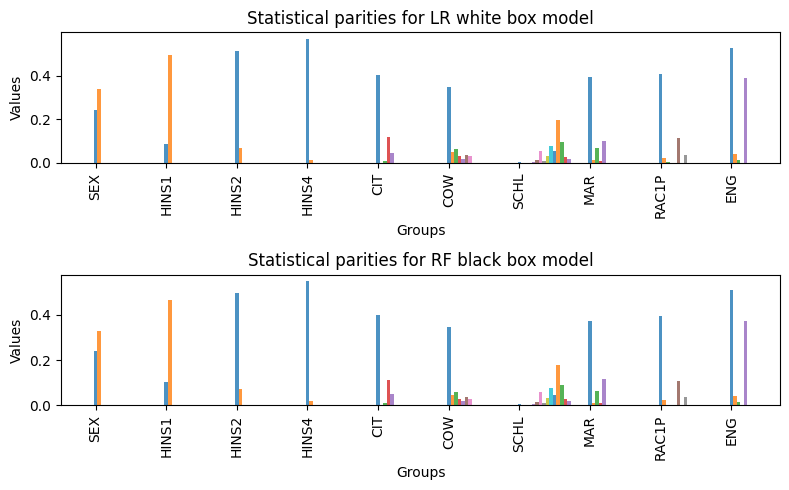

In [ ]:
## Plotting the statistical parities
# Data
SPWB = [SPSEX,SPHINS1, SPHINS2,SPHINS4,SPCIT, SPCOW, SPSCHL, SPMAR,SPRAC1P,SPENG]
SPBB = [SPSEXB,SPHINS1B, SPHINS2B,SPHINS4B,SPCITB, SPCOWB, SPSCHLB, SPMARB,SPRAC1PB,SPENGB]

SPWB = [arr.tolist() for arr in SPWB]
SPBB = [arr.tolist() for arr in SPBB]


########### White box
# Determine the max number of bars in a group
max_bars = max(len(group) for group in SPWB)

# Pad shorter groups with NaN to align them
padded_values = [group + [np.nan] * (max_bars - len(group)) for group in SPWB]

# Convert to NumPy array for easy manipulation
data_matrix = np.array(padded_values).T

# Plot settings
#x_labels=["Sex", "Insurance, gov ass.", "Insurance, self bought", "Insurance, employee", "Citizenship", "Working class", "Educational attainment", "Marital status", "Race", "English abilities"]
x_labels=["SEX","HINS1","HINS2","HINS4","CIT","COW","SCHL","MAR","RAC1P","ENG"]
bar_width = 0.15
x = np.arange(len(SPWB))*3

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 5))  # 2 rows, 1 column

# Statistical parities white box model
for i in range(max_bars):
    axes[0].bar(x + i * bar_width, data_matrix[i], width=bar_width,  alpha=0.8) 

axes[0].set_xlabel("Groups")
axes[0].set_ylabel("Values")
axes[0].set_title("Statistical parities for LR white box model")
axes[0].set_xticks(x)
axes[0].set_xticklabels(x_labels, rotation=90)

########### Black box
# Determine the max number of bars in a group
max_bars = max(len(group) for group in SPBB)

# Pad shorter groups with NaN to align them
padded_values = [group + [np.nan] * (max_bars - len(group)) for group in SPBB]

# Convert to NumPy array for easy manipulation
data_matrix = np.array(padded_values).T

# Statistical parities black box model
for i in range(max_bars):
    axes[1].bar(x + i * bar_width, data_matrix[i], width=bar_width,  alpha=0.8) 

axes[1].set_xlabel("Groups")
axes[1].set_ylabel("Values")
axes[1].set_title("Statistical parities for RF black box model")
axes[1].set_xticks(x)
axes[1].set_xticklabels(x_labels, rotation=90)



plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Equilized odds

In [ ]:
## Calculating statistical parities

## Sex
EOSEX=np.zeros(2)
EOSEX[0]=np.mean(y_predWB & X_testS["SEX_2"] & y_test)
EOSEX[1]=np.mean(y_predWB & 1-X_testS["SEX_2"] & y_test)

## Insurance type 1
EOHINS1=np.zeros(2)
EOHINS1[0]=np.mean(y_predWB & X_testS["HINS1_2"] & y_test)
EOHINS1[1]=np.mean(y_predWB & 1-X_testS["HINS1_2"] & y_test)

## Insurance type 2
EOHINS2=np.zeros(2)
EOHINS2[0]=np.mean(y_predWB & X_testS["HINS2_2"] & y_test)
EOHINS2[1]=np.mean(y_predWB & 1-X_testS["HINS2_2"] & y_test)

## Insurance type 4
EOHINS4=np.zeros(2)
EOHINS4[0]=np.mean(y_predWB & X_testS["HINS4_2"] & y_test)
EOHINS4[1]=np.mean(y_predWB & 1-X_testS["HINS4_2"] & y_test)

## Citizenship
# Allocating space for statistical parities and index column for group 1
EOCIT=np.zeros(5)
X_testS["CIT_1"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 6):
    EOCIT[i-1]=np.mean(y_predWB & X_testS[f"CIT_{i}"] & y_test)
    # Creating an index column for group 1
    X_testS["CIT_1"]=X_testS["CIT_1"]- X_testS[f"CIT_{i}"]
# Statistical parity for group 1
EOCIT[0]=np.mean(y_predWB & X_testS["CIT_1"] & y_test)


## Working class
# Allocating space for statistical parities and index column for group 1
EOCOW=np.zeros(8)
X_testS["COW_1.0"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 9):
    EOCOW[i-1]=np.mean(y_predWB & X_testS[f"COW_{i}.0"] & y_test)
    # Creating an index column for group 1
    X_testS["COW_1.0"]=X_testS["COW_1.0"]- X_testS[f"COW_{i}.0"]
# Statistical parity for group 1
EOCOW[0]=np.mean(y_predWB & X_testS["COW_1.0"] & y_test)


## Educational attainment
# Allocating space for statistical parities and index column for group 1
EOSCHL=np.zeros(15)
X_testS["SCHL_1.0"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 16):
    EOSCHL[i-1]=np.mean(y_predWB & X_testS[f"SCHL_{i}.0"] & y_test)
    # Creating an index column for group 1
    X_testS["SCHL_1.0"]=X_testS["SCHL_1.0"]- X_testS[f"SCHL_{i}.0"]
# Statistical parity for group 1
EOSCHL[0]=np.mean(y_predWB & X_testS["SCHL_1.0"] & y_test)


## Marital status
# Allocating space for statistical parities and index column for group 1
EOMAR=np.zeros(5)
X_testS["MAR_1"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 6):
    EOMAR[i-1]=np.mean(y_predWB & X_testS[f"MAR_{i}"] & y_test)
    # Creating an index column for group 1
    X_testS["MAR_1"]=X_testS["MAR_1"]- X_testS[f"MAR_{i}"]
# Statistical parity for group 1
EOMAR[0]=np.mean(y_predWB & X_testS["MAR_1"] & y_test)


## Race code
# Allocating space for statistical parities and index column for group 1
EORAC1P=np.zeros(8)
X_testS["RAC1P_1"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 9):
    EORAC1P[i-1]=np.mean(y_predWB & X_testS[f"RAC1P_{i}"] & y_test)
    # Creating an index column for group 1
    X_testS["RAC1P_1"]=X_testS["RAC1P_1"]- X_testS[f"RAC1P_{i}"]
# Statistical parity for group 1
EORAC1P[0]=np.mean(y_predWB & X_testS["RAC1P_1"] & y_test)


## English abilities
# Allocating space for statistical parities and index column for group 1
EOENG=np.zeros(5)
X_testS["ENG_1.0"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 5):
    EOENG[i-1]=np.mean(y_predWB & X_testS[f"ENG_{i}.0"] & y_test)
    # Creating an index column for group 1
    X_testS["ENG_1.0"]=X_testS["ENG_1.0"]- X_testS[f"ENG_{i}.0"]
# Statistical parity for group 1
EOENG[0]=np.mean(y_predWB & X_testS["ENG_1.0"] & y_test)
# Statistical parity for group 5
EOENG[4]=np.mean(y_predWB & X_testS["ENG_nan"] & y_test)

In [ ]:
## Calculating statistical parities

## Sex
EOSEXB=np.zeros(2)
EOSEXB[0]=np.mean(y_predBB & X_testS["SEX_2"] & y_test)
EOSEXB[1]=np.mean(y_predBB & 1-X_testS["SEX_2"] & y_test)

## Insurance type 1
EOHINS1B=np.zeros(2)
EOHINS1B[0]=np.mean(y_predBB & X_testS["HINS1_2"] & y_test)
EOHINS1B[1]=np.mean(y_predBB & 1-X_testS["HINS1_2"] & y_test)

## Insurance type 2
EOHINS2B=np.zeros(2)
EOHINS2B[0]=np.mean(y_predBB & X_testS["HINS2_2"] & y_test)
EOHINS2B[1]=np.mean(y_predBB & 1-X_testS["HINS2_2"] & y_test)

## Insurance type 4
EOHINS4B=np.zeros(2)
EOHINS4B[0]=np.mean(y_predBB & X_testS["HINS4_2"] & y_test)
EOHINS4B[1]=np.mean(y_predBB & 1-X_testS["HINS4_2"] & y_test)

## Citizenship
# Allocating space for statistical parities and index column for group 1
EOCITB=np.zeros(5)
X_testS["CIT_1"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 6):
    EOCITB[i-1]=np.mean(y_predBB & X_testS[f"CIT_{i}"] & y_test)
    # Creating an index column for group 1
    X_testS["CIT_1"]=X_testS["CIT_1"]- X_testS[f"CIT_{i}"]
# Statistical parity for group 1
EOCITB[0]=np.mean(y_predBB & X_testS["CIT_1"] & y_test)


## Working class
# Allocating space for statistical parities and index column for group 1
EOCOWB=np.zeros(8)
X_testS["COW_1.0"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 9):
    EOCOWB[i-1]=np.mean(y_predBB & X_testS[f"COW_{i}.0"] & y_test)
    # Creating an index column for group 1
    X_testS["COW_1.0"]=X_testS["COW_1.0"]- X_testS[f"COW_{i}.0"]
# Statistical parity for group 1
EOCOWB[0]=np.mean(y_predBB & X_testS["COW_1.0"] & y_test)


## Educational attainment
# Allocating space for statistical parities and index column for group 1
EOSCHLB=np.zeros(15)
X_testS["SCHL_1.0"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 16):
    EOSCHLB[i-1]=np.mean(y_predBB & X_testS[f"SCHL_{i}.0"] & y_test)
    # Creating an index column for group 1
    X_testS["SCHL_1.0"]=X_testS["SCHL_1.0"]- X_testS[f"SCHL_{i}.0"]
# Statistical parity for group 1
EOSCHLB[0]=np.mean(y_predBB & X_testS["SCHL_1.0"] & y_test)


## Marital status
# Allocating space for statistical parities and index column for group 1
EOMARB=np.zeros(5)
X_testS["MAR_1"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 6):
    EOMARB[i-1]=np.mean(y_predBB & X_testS[f"MAR_{i}"] & y_test)
    # Creating an index column for group 1
    X_testS["MAR_1"]=X_testS["MAR_1"]- X_testS[f"MAR_{i}"]
# Statistical parity for group 1
EOMARB[0]=np.mean(y_predBB & X_testS["MAR_1"] & y_test)


## Race code
# Allocating space for statistical parities and index column for group 1
EORAC1PB=np.zeros(8)
X_testS["RAC1P_1"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 9):
    EORAC1PB[i-1]=np.mean(y_predBB & X_testS[f"RAC1P_{i}"] & y_test)
    # Creating an index column for group 1
    X_testS["RAC1P_1"]=X_testS["RAC1P_1"]- X_testS[f"RAC1P_{i}"]
# Statistical parity for group 1
EORAC1PB[0]=np.mean(y_predBB & X_testS["RAC1P_1"] & y_test)


## English abilities
# Allocating space for statistical parities and index column for group 1
EOENGB=np.zeros(5)
X_testS["ENG_1.0"]=np.repeat(np.array([1]), len(X_testS))
# Statistical parities for groups
for i in range(2, 5):
    EOENGB[i-1]=np.mean(y_predBB & X_testS[f"ENG_{i}.0"] & y_test)
    # Creating an index column for group 1
    X_testS["ENG_1.0"]=X_testS["ENG_1.0"]- X_testS[f"ENG_{i}.0"]
# Statistical parity for group 1
EOENGB[0]=np.mean(y_predBB & X_testS["ENG_1.0"] & y_test)
# Statistical parity for group 5
EOENGB[4]=np.mean(y_predBB & X_testS["ENG_nan"] & y_test)

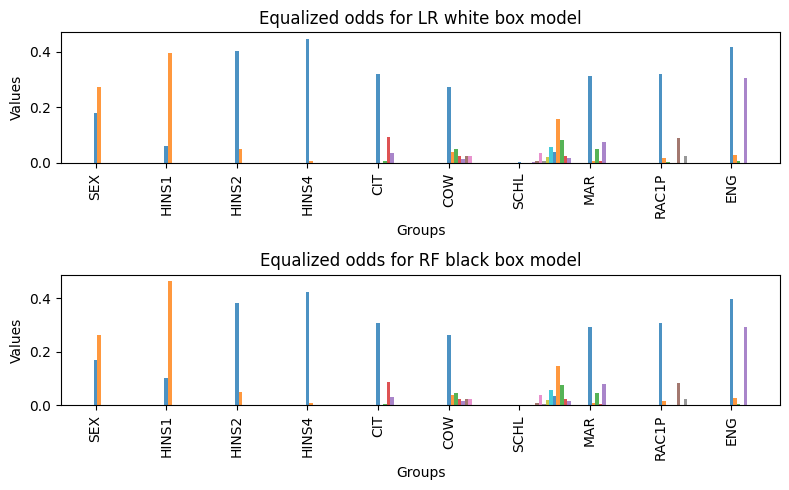

In [ ]:
## Plotting the statistical parities
# Data
EOWB = [EOSEX,EOHINS1, EOHINS2,EOHINS4,EOCIT, EOCOW, EOSCHL, EOMAR,EORAC1P,EOENG]
EOBB = [EOSEXB,SPHINS1B, EOHINS2B,EOHINS4B,EOCITB, EOCOWB, EOSCHLB, EOMARB,EORAC1PB,EOENGB]

EOWB = [arr.tolist() for arr in EOWB]
EOBB = [arr.tolist() for arr in EOBB]


########### White box
# Determine the max number of bars in a group
max_bars = max(len(group) for group in EOWB)

# Pad shorter groups with NaN to align them
padded_values = [group + [np.nan] * (max_bars - len(group)) for group in EOWB]

# Convert to NumPy array for easy manipulation
data_matrix = np.array(padded_values).T

# Plot settings
#x_labels=["Sex", "Insurance, gov ass.", "Insurance, self bought", "Insurance, employee", "Citizenship", "Working class", "Educational attainment", "Marital status", "Race", "English abilities"]
x_labels=["SEX","HINS1","HINS2","HINS4","CIT","COW","SCHL","MAR","RAC1P","ENG"]
bar_width = 0.15
x = np.arange(len(EOWB))*3

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 5))  # 2 rows, 1 column

# Statistical parities white box model
for i in range(max_bars):
    axes[0].bar(x + i * bar_width, data_matrix[i], width=bar_width,  alpha=0.8) 

axes[0].set_xlabel("Groups")
axes[0].set_ylabel("Values")
axes[0].set_title("Equalized odds for LR white box model")
axes[0].set_xticks(x)
axes[0].set_xticklabels(x_labels, rotation=90)

########### Black box
# Determine the max number of bars in a group
max_bars = max(len(group) for group in EOBB)

# Pad shorter groups with NaN to align them
padded_values = [group + [np.nan] * (max_bars - len(group)) for group in EOBB]

# Convert to NumPy array for easy manipulation
data_matrix = np.array(padded_values).T

# Statistical parities black box model
for i in range(max_bars):
    axes[1].bar(x + i * bar_width, data_matrix[i], width=bar_width,  alpha=0.8) 

axes[1].set_xlabel("Groups")
axes[1].set_ylabel("Values")
axes[1].set_title("Equalized odds for RF black box model")
axes[1].set_xticks(x)
axes[1].set_xticklabels(x_labels, rotation=90)



plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()